In [1]:
# Jupyter Notebook Chapter 12 Exercises Program
# DSC 530
# Week 10
# EDA Assignment Week 10
# David Berberena
# 2/18/2024

# Program Start

# Importing of needed libraries and data to establish the correct coding environment

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from IPython.display import display


Downloaded mj-clean.csv


In [2]:
# Exercise functions are taken from the Exercise file to establish the correct coding environment

transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])

def GroupByDay(transactions, func=np.mean):

    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)

    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

def GroupByQualityAndDay(transactions):

    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

dailies = GroupByQualityAndDay(transactions)

In [9]:
# Exercise functions are taken from the Exercise file to establish the correct coding environment

def RunLinearModel(daily):
    
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

def PlotFittedValues(model, results, label=""):

    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")
    
def PlotLinearModel(daily, name):

    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(
        title="Fitted values",
        xlabel="Years",
        xlim=[-0.1, 3.8],
        ylabel="Price per gram ($)",
    )
    
def SimulateResults(daily, iters=101, func=RunLinearModel):

    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):

    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq
        
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):

    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")
    
def SerialCorr(series, lag=1):
    
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [13]:
# Exercise 12-1

# The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect 
# prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in 
# Section 11.3. Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. 
# You will have to write a version of RunLinearModel that runs that quadratic model, but after that you should be able to 
# reuse code from the chapter to generate predictions.

# I have modified the RunLinearModel() function to create a RunQuadraticModel() function based on the quadratic formula

# Linear formula is y(model) = mx(years) + b(ppg), so I altered the formula to make it read as quadratic by squaring the
# years variable and plugging it in alongside the years variable for a multiple regression model. The quadratic formula now
# reads as y(model) = ax**2(years**2) + bx(years) + c(ppg)

def RunQuadraticModel(daily):

    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

# Results code is taken from the Exercise file and changed to include the new function

name = "high"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Thu, 15 Feb 2024   Prob (F-statistic):          4.57e-164
Time:                        09:46:04   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1164      0.084    -13.326      0.000      -1.281      -0.952
years2         0.1131      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

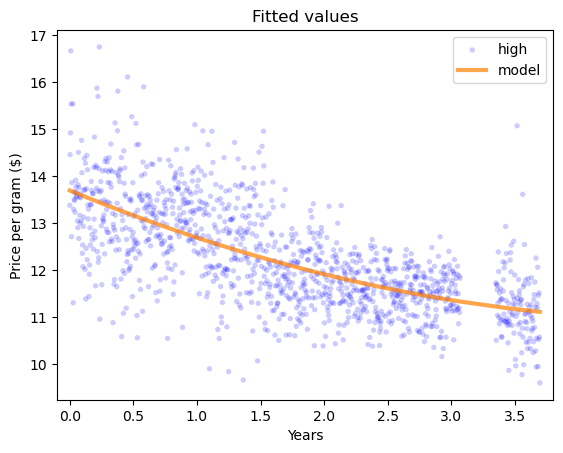

In [14]:
# To plot the fitted values, I will be altering the PlotLinearModel() function to make a new PlotQuadraticModel() function

def PlotQuadraticModel(daily, name):

    model, results = RunQuadraticModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(
        title="Fitted values",
        xlabel="Years",
        xlim=[-0.1, 3.8],
        ylabel="Price per gram ($)",
    )
    
# Output code is taken from the Exercise file and modified 

name = "high"
daily = dailies[name]

PlotQuadraticModel(daily, name)

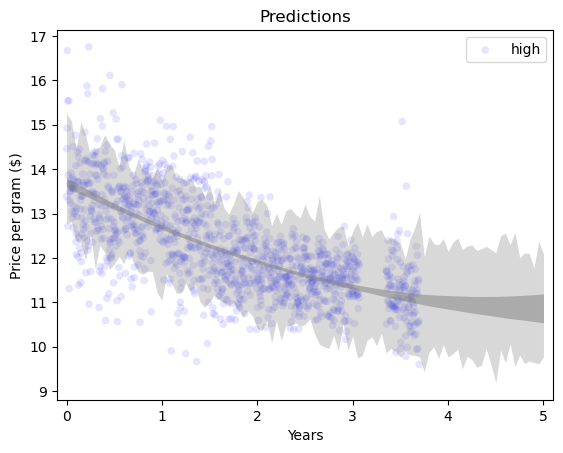

In [16]:
# To generate and plot predictions using the established quadratic model, I have modified the Exercise file output code to 
# use the RunQuadraticModel() function created

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
xlim = years[0] - 0.1, years[-1] + 0.1
thinkplot.Config(
    title="Predictions", xlabel="Years", xlim=xlim, ylabel="Price per gram ($)"
)

In [30]:
# Exercise 12-2

# Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from Section 9.2. It should take 
# a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value 
# of the observed correlation. Use this class to test whether the serial correlation in raw price data is statistically 
# significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

# Creating the SerialCorrelationTest class as an extension of HypothesisTest (part of the thinkstats2 module) is best done
# by passing the HypothesisTest class as an argument for the new class

class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    # The below instance methods are taken from the HypothesisTest class in thinkstats2 starting from line 2975 
    
    # The body of the TestStatistic instance method has been created to return the absolute value of the serial correlation 
    # of a series and a lagged version of the same series 

    def TestStatistic(self, data):

        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat
    
    # The body of the RunModel instance method has been created to randomly scramble the order of elements in the series
    
    # To keep the observations and lagged observations together while values are scrambled, I chose to use the permutation()
    # function from the NumPy library and return the permutated observation and its corresponding lagged observation
    
    def RunModel(self):

        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
    
# Output code establishes the dataset like before, the variable (ppg for the raw price data), stores the absolute value of 
# the serial correlation of the first observation/lagged observation pair in a variable, siphons the p-value of the 
# coefficient using the PValue() instance method under the HypothesisTest class in the thinkstats2 module (line 2989), and
# prints the serial correlation coefficient and the p-value side-by-side
    
name = "high"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947381 0.0


In [31]:
# Output code for the linear model's residuals is modified to show the extractiob of the residuals from the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506262 0.007


In [32]:
# The quadratic model's residuals output code is the same as the linear model, save for the change in function

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289919 0.049
